# Mahilo As Your Agent Control Plane

With the advent of increasingly powerful models, the use of specialized agents would grow considerably. We already have powerful agents that you can hire for your organization, performing tasks like marketing, sales or product management. In a world where these agents are expected to work together, it becomes important that they are aware of each other and can share information as needed to get better at their jobs, instead of working in silos.

![Mahilo Agents](./mahilo_integrations1.png)

mahilo is a multi-agent human-in-the-loop framework that ties agents together while allowing humans to supervise them in real-time. Bring any agent, irrespective of the framework it is written in (or from a proprietary service) and mahilo can enable you to connect it to your team of agents, allowing cross-communication and enforcement of common company policies.

Let's look at an example using LangGraph and PydanticAI agents (the two frameworks supported at the moment).

# Use Case: Sales, Marketing, and Product Teams in a Company

Let's take the use case of a company with three teams that need to coordinate with each other across multiple tasks. The scenario we will focus on is this: Feature Launch Coordination.

The setup is such that each team gets an agent that is supervised by a human supervisor. We will start our discourse with the sales agent about a potential new feature, which will then use its capabilities to decide what course of action to take, eventually discussing the idea and its roadmap with the product agent, which in turn gets the marketing agent in the loop for preparing promotion material. All of this, while their human supervisors have direct knowledge of what's going on and can guide and approve the agents' actions.

# Building the Agents

## Setup

Let's first install some libraries and set our OpenAI API key, which is the provider we will use for the demo.

In [1]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
!pip install -r requirements.txt

## Marketing Agent (LangGraph)

We'll start with the marketing agent and will utilize LangGraph to build it. To build an agent that can be registered with mahilo later, all you need to do is add a tool that mahilo provides, to your ToolNode when defining your graph. 

You can then go about building the agent without worrying about any additional syntax and choose whatever tools suit your needs. In the example below, we have chosen three tools for the marketing agent:

- analyze_content_performance: Analyze the performance of the content across social media platforms
- research_trending_topics: Research current trending topics in the industry
- generate_content_calendar: Create a content calendar based on trends and performance

We expect this agent to answer questions about what platforms have performed well, what is the current market sentiment around relevant topics and to generate content calendars based on all the information it gathers. You can imagine that this agent will benefit from knowing specific product details when choosing what to promote, from the product team and also where most sales leads are coming from, from the sales team.

In [4]:
from typing import Annotated, Dict, List

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# the tool that mahilo provides out-of-the-box
from mahilo.integrations.langgraph.tools import get_chat_with_agent_tool_langgraph

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

from langchain_core.tools import tool

@tool
def analyze_content_performance(content: str) -> str:
  """Analyze the performance of the content across social media platforms"""
  return "The content is performing well on LinkedIn."

@tool
def research_trending_topics(industry: str) -> List[str]:
    """Research current trending topics in the industry"""
    return ["Lot of buzz around mahilo agents and its multi-agent capabilities"]

@tool
def generate_content_calendar(timeframe: str) -> Dict[str, str]:
    """Create a content calendar based on trends and performance"""
    return {
        "January": "Mahilo Agents: Multi-Agent Capabilities",
        "February": "Integrations with mahilo",
    }

chat_with_agent_tool = get_chat_with_agent_tool_langgraph()
tools = [analyze_content_performance, research_trending_topics, generate_content_calendar, chat_with_agent_tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

The code above builds a simple graph that starts at the chatbot and has a tools node that is called conditionally if the response of the chatbot contains any tool calls. The functions have dummy logic but you can imagine that this agent in production could be a state-of-the-art, well-tested system that specializes in marketing.

> ℹ️ mahilo also supports setting thread ID when running the agent. We will see this in the control plane section below when we bring these agents together.

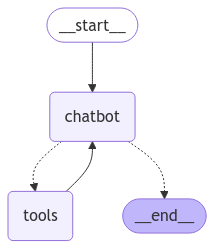

In [30]:
from IPython.display import Image, display

graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Product Agent (PydanticAI)

The next agent we will build is a product manager agent, built using PydanticAI. To build an agent that can later be integrated into mahilo, you don't have to perform any additional tasks! mahilo can take your PydanticAI agent as it is, and integrate it into its network of AI agents.

The product agent below has the following functions:

- analyze_feature_request: Analyze viability and impact of requested features
- get_product_roadmap: Get current product roadmap and timeline from the database connection
- analyze_usage_patterns: Analyze how customers are using specific features

We expect this agent to be able to analyze a feature request, figure out when it is planned and then discuss with its human supervisor if it needs to be reprioritized. It can also analyze patterns and come up with features to build. You can imagine that this agent would be really helpful for the sales agent to get up-to-date information about the product and motivate priorities based on customer feedback. This agent also has to work closely with the marketing team to keep them in the loop for upcoming features.

In [16]:
from dataclasses import dataclass
from typing import Dict, List

from pydantic import BaseModel

from pydantic_ai import Agent, RunContext


class DatabaseConn:
    """This is a fake database for example purposes.

    In reality, you'd be connecting to an external database
    (e.g. PostgreSQL) to get information about customers.
    """

    @classmethod
    async def get_roadmap(cls, *, product_name: str) -> str | None:
        if product_name == 'mahilo':
            return 'Build mahilo Agents'

@dataclass
class ProductDependencies:
    product_name: str
    db: DatabaseConn

class FeatureAnalysis(BaseModel):
    feature_name: str
    priority: int
    requests_for_human: List[str]
    comments: str

product_agent = Agent(
    'openai:gpt-4o-mini',
    deps_type=ProductDependencies,
    result_type=FeatureAnalysis,
    system_prompt=(
        'You are a product manager in our company,'
        'you are responsible for the product roadmap and feature requests.'
    ),
)

@product_agent.tool
async def analyze_feature_request(ctx: RunContext[ProductDependencies], feature: str) -> str:
    """Analyze viability and impact of requested features"""
    return "Based on analysis, mahilo integration is in our Q3 roadmap, coming in a few months."

@product_agent.tool
async def get_product_roadmap(ctx: RunContext[ProductDependencies]) -> str:
    """Get current product roadmap and timeline"""
    roadmap = await ctx.deps.db.get_roadmap(product_name=ctx.deps.product_name)
    return roadmap

@product_agent.tool
async def analyze_usage_patterns(ctx: RunContext[ProductDependencies], feature: str) -> Dict[str, float]:
    """Analyze how customers are using specific features"""
    return {
        'mahilo integration': 0.5,
        'New feature': 0.3,
    }


The code above defines a product agent that has some product dependencies that should be injected at runtime, like the project name and the database connection. mahilo supports passing them in when activating your mahilo agents, something we will see in the control plane section below.

The output of the model is also expected to follow the FeatureAnalysis model that is defined with parameters like human review requests and other comments. The mahilo agent in the websocket connection respects this and also formats this correctly for easy viewing.

## Sales Agent (mahilo)

Let's now build our final agent, the sales agent that will be built using mahilo natively. To create agents in mahilo, all you need to do is define a dictionary that links your tool definitions (in OpenAI spec) and your Python functions together and then we can use the `BaseAgent` class to define an instance of our agent.

The sales agent has the following functions:

- analyze_lead_sources: Analyze effectiveness of different lead sources to see where the traffic is coming from
- collect_feature_feedback: Analyse past interactions and collect customer feedback about desired features
- generate_sales_insights: Generate insights about sales patterns and customer preferences

We expect the sales agent to be able to answer questions about the source of leads coming in, to collect feedback on features from the users they talk to and identify trends and then generate insights based on this data. You can imagine that the source of leads is an interesting metric for the marketing team to refocus efforts when pushing content out, and the product team can benefit immensely from the feedback from real users on what feature to prioritize next.

In [12]:
def analyze_lead_sources() -> str:
    """Analyze effectiveness of different lead sources"""
    return """
    We've been getting more leads from Reddit lately. 
    """

def collect_feature_feedback() -> str:
    """Analyse past interactions and collect customer feedback about desired features"""
    return """I've analyzed last month's calls. 40 percent of all 
    enterprise customers are interested in an integration with mahilo. 
    """

def generate_sales_insights() -> str:
    """Generate insights about sales patterns and customer preferences"""
    return """
    We should focus on getting more enterprise customers and integrations with mahilo. 
    """

sales_tools = [
    {
        "tool": {
            "type": "function",
            "function": {
                "name": "analyze_lead_sources",
                "description": "Analyze effectiveness of different lead sources",
                "parameters": {}
            }
        },
        "function": analyze_lead_sources,
    },
    {
        "tool": {
            "type": "function",
            "function": {
                "name": "collect_feature_feedback",
                "description": "Analyse past interactions and collect customer feedback about desired features",
                "parameters": {}
            }
        },
        "function": collect_feature_feedback,
    },
    {
        "tool": {
            "type": "function",
            "function": {
                "name": "generate_sales_insights",
                "description": "Generate insights about sales patterns and customer preferences",
                "parameters": {}
            }
        },
        "function": generate_sales_insights,
    }
]

The code above defines our tools and the Python functions. We can now use it in our BaseAgent in the section below.

# Control Plane For Your Agents

Once you have the independent agents ready and functional, the ideal next step is to bring them together in a team where they can choose to interact with other agents as the need arises. This expands their scope and makes them more useful as opposed to working in silos without knowledge of the company at large.

One other benefit of a control plane like this is that you can enforce company-wide policies like ethics, and communication patterns among others. Let's look at the code below to see how mahilo enables this realtime collaboration between your agents.

In [20]:
from mahilo.agent import BaseAgent
from mahilo.agent_manager import AgentManager
from mahilo.integrations.pydanticai.agent import PydanticAIAgent
from mahilo.integrations.langgraph.agent import LangGraphAgent
from mahilo.server import ServerManager

# additional prompts to make the agents aware of the team they are now a part of
product_agent_prompt = """
Use the analyze_feature_request tool when asked about a feature.
You can then request approvals from your user (human) when you feel there's a need to
prioritize a feature. Don't ask too many questions to other agents, assume stuff when there's not enough information. this is a demo.
"""

marketing_agent_prompt = """
When notified of new features, research trending topics and generate a content calendar. Give your recommendations on what to do, to your user (human). 
Use the analyze_content_performance tool when asked about the performance of the content. You should also ask the sales agent for what channels have brought in more leads.
"""

sales_agent_prompt = """
When asked about analysing certain features, gather user feedback on it and present to your user (human).
If you spot a feature that has been requested a lot, you can ask the product agent about its status.
For all other scenarios, only call tools or actions when asked to do so. Don't do everything together, wait for prompts.
"""

# wrapper class to make your pydantic agent a mahilo agent
product_agent = PydanticAIAgent(
    pydantic_agent=product_agent,
    name="ProductAgent",
    description=product_agent_prompt,
    can_contact=[],
    short_description="Product agent",
)

# wrapper class to make your langgraph agent a mahilo agent
marketing_agent = LangGraphAgent(
    langgraph_agent=graph_builder,
    name="MarketingAgent",
    description=marketing_agent_prompt,
    can_contact=[],
    short_description="Marketing agent",
)

# the base mahilo agent
sales_agent = BaseAgent(
    name="SalesAgent",
    type="sales_agent",
    description=sales_agent_prompt,
    short_description="Sales agent",
    tools=sales_tools,
)

# an agent manager is like a team
team = AgentManager()
team.register_agent(product_agent)
team.register_agent(marketing_agent)
team.register_agent(sales_agent)

# activate the pydantic agent with the right dependencies
product_agent.activate(dependencies=ProductDependencies(product_name="Mahilo", db=DatabaseConn()))
# activate the langgraph agent with a thread id
marketing_agent.activate(server_id="1")
# activate the base agent with no dependencies
sales_agent.activate()

# create a server with your team
server = ServerManager(team)


When defining mahilo agents for your LangGraph and PydanticAI agents, you just have to wrap your agent instances in the classes that mahio provides, LangGraphAgent and PydanticAIAgent respectively. You can provide a name to your agents, which is what will be visible to the other agents when they want to communicate, and a description which will be dynamically added to the main system prompt. This description helps facilitate the communication and makes the agents aware of the team they are now in.

When adding your agent to mahilo, you get the following benefits:

- Enable real-time communication with your agents through voice and chat--mahilo agents can communicate in real-time with each other and with their human supervisors using websockets and OpenAI's Realtime API.
- Knowledge of other agent conversations and the ability to ask questions/share information with other agents as needed.
- Ability for you to design complex multi-agent architectures like hierarchical patterns or peer-to-peer networks using mahilo's can_contact property that every agent can configure.
- All agent communication is tracked and logged so you can audit how the collaboration happened to debug and explain outcomes.

## Starting The Server

Now, once you have defined your server with your team of agents, you can start it to spawn a websocket server that you can connect to using your terminal.

In [26]:
import nest_asyncio

# run the server
nest_asyncio.apply()
asyncio.run(server.run())

INFO:     Started server process [54]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [54]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│   2                                                                                              │
│   3 # run the server                                                                             │
│   4 nest_asyncio.apply()                                                                         │
│ ❱ 5 asyncio.run(server.run())                                                                    │
│   6                                                                                              │
│                                                                                                  │
│ /shared-libs/python3.11/py-core/lib/python3.11/site-packages/nest_asyncio.py:29 in run           │
│                                                                                                  │
│    26 │   def run(main, *, debug=False):                                                         │
│    27 │   │   loop = asyncio.get_event_loop()                                                    │
│    28 │   │   loop.set_debug(debug)                                                              │
│ ❱  29 │   │   task = asyncio.ensure_future(main)                                                 │
│    30 │   │   try:                                                                               │
│    31 │   │   │   return loop.run_until_complete(task)                                           │
│    32 │   │   finally:                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.11/asyncio/tasks.py:659 in ensure_future                                  │
│                                                                                                  │
│   656 │                                                                                          │
│   657 │   If the argument is a Future, it is returned directly.                                  │
│   658 │   """                                                                                    │
│ ❱ 659 │   return _ensure_future(coro_or_future, loop=loop)                                       │
│   660                                                                                            │
│   661                                                                                            │
│   662 def _ensure_future(coro_or_future, *, loop=None):                                          │
│                                                                                                  │
│ /usr/local/lib/python3.11/asyncio/tasks.py:674 in _ensure_future                                 │
│                                                                                                  │
│   671 │   │   │   coro_or_future = _wrap_awaitable(coro_or_future)                               │
│   672 │   │   │   called_wrap_awaitable = True                                                   │
│   673 │   │   else:                                                                              │
│ ❱ 674 │   │   │   raise TypeError('An asyncio.Future, a coroutine or an awaitable '              │
│   675 │   │   │   │   │   │   │   'is required')                                                 │
│   676 │                                                                                          │
│   677 │   if loop is None:                                                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: An asyncio.Future, a coroutine or an awaitable is 

## Connecting to The Server

With the server running, start a new terminal. You can connect to your mahilo server using the command below.

In [ ]:
python mahilo/mahilo/client.py --agent-name ProductAgent

You can spin up different terminals for each of the agents, changing the --agent-name flag to fit the agent you wanna establish a channel with. 

> ℹ️ By default, the client connects to localhost:8000 but in scenarios where you choose to deploy it remotely, you can pass in the host with the --host flag.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=be74d6a6-21c2-4c18-b582-69612ec2acf1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>